In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
# Python code to create the dataset
with open("pattern_data.txt", "w") as f:
    for _ in range(100000):  # Adjust number of repetitions as needed
        f.write("1,2,3,4,5,")

In [3]:
# hyperparameters
batch_size = 8 # how many independent sequences will we process in parallel?
input_size = 128 # what is the maximum context length for predictions?
max_iters = 20000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
eval_iters = 200
n_embedding = 384
n_head = 24
n_layer = 12
dropout = 0.2
# ------------

cuda


In [4]:

# 7 habits of highly effective people
with open('pattern_data.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    #print(text)
print(len(text))


1000000


In [5]:
# here are all the unique characters that occur in this text
print(set(text))
print(list(set(text)))
print(sorted(list(set(text))))
print(len(sorted(list(set(text)))))
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

#print(stoi[1])
print(encode(['1','2','3']))
print(decode(encode(['1','2','3'])))

{',', '4', '1', '2', '3', '5'}
[',', '4', '1', '2', '3', '5']
[',', '1', '2', '3', '4', '5']
6
[1, 2, 3]
123


In [6]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

print(train_data[0:100])
print(text[0:100])
print(sorted(list(set(text))))


#input_size = 8
print(train_data[0:input_size+1])
print(text[0:input_size+1])


x = train_data[0:input_size]
y = train_data[1:input_size+1]

for t in range(input_size):
  context = x[0:t+1]
  target = y[t]

tensor([1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0,
        3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0,
        5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0,
        2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0,
        4, 0, 5, 0])
1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,
[',', '1', '2', '3', '4', '5']
tensor([1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0,
        3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0,
        5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0,
        2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0,
        4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0,
        1, 0, 2, 0, 3, 0, 4, 0, 5])
1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1

In [7]:
# data loading
#torch.manual_seed(1337)
#batch_size = 4
#input_size = 8

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - input_size, (batch_size,))
    x = torch.stack([data[i:i+input_size] for i in ix])
    y = torch.stack([data[i+1:i+input_size+1] for i in ix])
    
    #print(f"x shape: {x.shape}, y shape: {y.shape}")
    #print(f"x dtype: {x.dtype}, y dtype: {y.dtype}")
    
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss,ttention_scores = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

xb, yb = get_batch('train')
print("input:")
print(xb.shape)
print(xb)
print("target:")
print(yb.shape)
print(yb)

for b in range(batch_size):
  for t in range(input_size):
    context = xb[ b, 0:t+1 ]
    target = yb[ b, t ]
    #print(context,"->",target)
    
    

input:
torch.Size([8, 128])
tensor([[3, 0, 4,  ..., 0, 1, 0],
        [1, 0, 2,  ..., 0, 4, 0],
        [3, 0, 4,  ..., 0, 1, 0],
        ...,
        [0, 3, 0,  ..., 5, 0, 1],
        [0, 5, 0,  ..., 2, 0, 3],
        [0, 4, 0,  ..., 1, 0, 2]], device='cuda:0')
target:
torch.Size([8, 128])
tensor([[0, 4, 0,  ..., 1, 0, 2],
        [0, 2, 0,  ..., 4, 0, 5],
        [0, 4, 0,  ..., 1, 0, 2],
        ...,
        [3, 0, 4,  ..., 0, 1, 0],
        [5, 0, 1,  ..., 0, 3, 0],
        [4, 0, 5,  ..., 0, 2, 0]], device='cuda:0')


In [8]:
class GateLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GateLayer, self).__init__()
        
        self.linear = nn.Linear(input_dim, n_embedding)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, encoder_output):
        # Compute gating vector
        gating_vector = self.linear(encoder_output)
        gating_vector = self.sigmoid(gating_vector)
        # Apply gating vector to encoder output
        gated_encoder_output = encoder_output * gating_vector
        
        return gated_encoder_output

# head_size = n_embedding // n_head  = 16
# n_embedding = 384
# n_head = 24

class Head(nn.Module):
    """ One head of self-attention with bias for repeating token '3' """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embedding, head_size, bias=False)
        self.query = nn.Linear(n_embedding, head_size, bias=False)
        self.value = nn.Linear(n_embedding, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(input_size, input_size)))

    def forward(self, x, return_qkv=False):
        B, T, C = x.shape
        k = self.key(x)  # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)

        # Compute attention scores
        attention_scores = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, T)
        
        # Detect the presence of token "3" and create a repetition effect in attention scores
        repeat_token_mask = (x[:, :, 0] == 3).float()  # Shape (B, T)
        
        # Expand repeat_token_mask to match attention_scores dimensions
        repeat_token_mask = repeat_token_mask.unsqueeze(1).expand(B, T, T)  # Shape (B, T, T)

        # Add high bias to attention scores for token "3"
        attention_scores = attention_scores + repeat_token_mask * 1000  # Amplify attention for "3"
        
        # Apply mask for causal attention
        attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        
        # Normalize with softmax
        attention_weights = F.softmax(attention_scores, dim=-1)  # (B, T, T)
        
        # Weighted sum of values
        v = self.value(x)  # (B, T, head_size)
        out = attention_weights @ v  # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        

        if return_qkv:
            return out, q, k, v, attention_scores
        else:
            return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.linear = nn.Linear(n_embedding, n_embedding)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.linear(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embedding):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embedding, 4 * n_embedding),
            nn.ReLU(),
            nn.Linear(4 * n_embedding, n_embedding),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embedding, n_head):
        # n_embedding: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embedding // n_head
        self.multi_head_attention = MultiHeadAttention(n_head, head_size)
        self.feed_forward = FeedFoward(n_embedding)
        self.layer_norm_1 = nn.LayerNorm(n_embedding)
        self.layer_norm_2 = nn.LayerNorm(n_embedding)

    def forward(self, x):
        x = x + self.multi_head_attention(self.layer_norm_1(x))
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

# super simple bigram model
class GPT2(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_into_embedding = nn.Embedding(vocab_size, n_embedding)
        self.position_embedding_table = nn.Embedding(input_size, n_embedding)
        
        #Input: (∗), IntTensor or LongTensor of arbitrary shape containing the indices to extract
        #Output: (∗,H), where * is the input shape and H=embedding_dim
        
        
        self.blocks = nn.Sequential(*[Block(n_embedding, n_head=n_head) for _ in range(n_layer)])
        self.layer_norm = nn.LayerNorm(n_embedding) # final layer norm
        #self.ffwd = FeedFoward(n_embedding)
        #self.sa_head = MultiHeadAttention(4,n_embedding//4)
        self.linear_head = nn.Linear(n_embedding, vocab_size)

    def forward(self, id_number_of_vector_x, targets=None):#target (B,T)
        #B,T =id_number_of_vector_x.shape
        #tok_embed = self.token_into_embedding(id_number_of_vector_x) #(B,T,C) (batch,Time,Channel)
        #logits = self.lm_head(tok_embed) #(B,T,vocab_size)

        B, T = id_number_of_vector_x.shape
        
        #print("===B===")
        #print(B)

        #print("===T===")
        #print(T)
        
        # id_number_of_vector_x and targets are both (B,T) tensor of integers
        #tok_emb = self.token_into_embedding(id_number_of_vector_x) # (B,T,C)
        #pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        #x = tok_emb + pos_emb # (B,T,C) + pos_emb across the batch
        #x = self.blocks(x) # (B,T,C)
        #x = self.ln_f(x) # (B,T,C)
        
        #x = self.sa_head(x) # (B,T,vocab_size)
        #logits = self.lm_head(x) # (B,T,vocab_size)

        # id_number_of_vector_x and targets are both (B,T) tensor of integers
        tok_emb = self.token_into_embedding(id_number_of_vector_x) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        #x = tok_emb + pos_emb # (B,T,C)
        #x = self.blocks(x) # (B,T,C)
        #x = self.ln_f(x) # (B,T,C)
        #x = self.sa_head(x) # (B,T,vocab_size)
        #x = self.ffwd(x)
        #logits = self.lm_head(x) # (B,T,vocab_size)

        x = tok_emb + pos_emb # (B,T,C) + pos_emb across the batch
        x = self.blocks(x) # (B,T,C)
        x = self.layer_norm(x) # (B,T,C)
        
        #print("===x===")
        #print(x.shape)
        #print("8 is   (B)  batch_size, # how many independent sequences will we process in parallel?")
        #print("128 is (T) input_size # what is the maximum context length for predictions?")
        #print("384 is (C) n_embedding")
        
        # Forward pass through blocks
        # Extract q, k, v from the first head of the first block
        x_norm = self.blocks[0].layer_norm_1(x)
        head = self.blocks[0].multi_head_attention.heads[0]
        out_head, q, k, v, attention_scores = head(x_norm, return_qkv=True)
        
        
        #x = self.sa_head(x) # (B,T,vocab_size)
        logits = self.linear_head(x) # (B,T,vocab_size)

        if targets == None:
          loss = None
        else:
          B, T, C = logits.shape # logit(p) = ln( p / ( 1 - p ) )
          logits = logits.view(B*T,C)
          targets = targets.view(B*T)
          loss = F.cross_entropy(logits,targets) # H( P, Q ) = -0.9 * log( 0.8 ) - 0.1 * log( 0.2 ) = 0.311, the lower the better matching
        return logits, loss, attention_scores

    def generate(self, id_number_of_vector_x, max_new_tokens):
        # id_number_of_vector_x is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop id_number_of_vector_x to the last input_size tokens
            id_number_of_vector_x_cut = id_number_of_vector_x[:, -input_size:]
            # get the predictions
            logits, loss, attention_scores = self(id_number_of_vector_x_cut)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            id_number_of_vector_x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            id_number_of_vector_x = torch.cat((id_number_of_vector_x, id_number_of_vector_x_next), dim=1) # (B, T+1)
        return id_number_of_vector_x


21.334278 M parameters
torch.Size([1024, 6]) tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward0>)


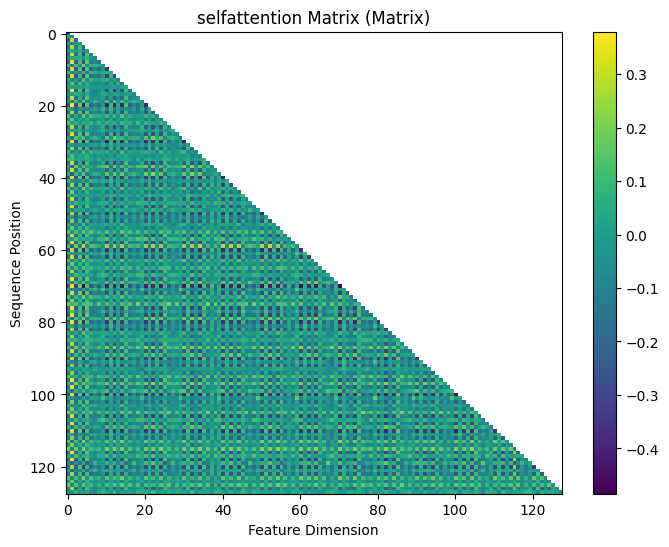

In [13]:
'''
model.load_state_dict(torch.load("./model"))
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
'''

model = GPT2()
model.load_state_dict(torch.load("./GPT2_simple_pattern"))
#model.load_state_dict(torch.load("./GPT2_rich_dad_poor_dad"))

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

logits, loss, attention_scores = m(xb,yb)
print(logits.shape,loss) # -ln(1/65) = 4.174387269896

import matplotlib.pyplot as plt

def visualize_matrix(matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix.cpu().detach().numpy(), aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Feature Dimension')
    plt.ylabel('Sequence Position')
    plt.show()

# Since q, k, v are tensors of shape (B, T, head_size), we'll visualize the first batch example
#visualize_matrix(q[0], 'Query Matrix (Q)')
#visualize_matrix(k[0], 'Key Matrix (K)')
#visualize_matrix(v[0], 'Value Matrix (V)')
visualize_matrix(attention_scores[0], 'selfattention Matrix (Matrix)')
#visualize_matrix(out_head[0], 'selfattention Matrix (Matrix)')


In [10]:

model = GPT2()
#model.load_state_dict(torch.load("./GPT2_Shakespeare"))
#model.load_state_dict(torch.load("./GPT2_rich_dad_poor_dad"))
#model.load_state_dict(torch.load("./GPT2_rich_dad_poor_dad_Fine-tuning_with_Custom_Datasets"))
#model.load_state_dict(torch.load("./GPT2_simple_pattern"))

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

id_number_of_vector_x = torch.zeros((1,1), dtype=torch.long)
print(id_number_of_vector_x)
print(torch.tensor([[32]]).to(device))
#print(decode(m.generate(torch.zeros((1,1), dtype=torch.long, device=device), max_new_tokens=10)[0].tolist()))

#print(decode(m.generate(torch.tensor([[32]]).to(device), max_new_tokens=100)[0].tolist()))

#torch.save(m.state_dict(), "./GPT2_simple_pattern")

21.334278 M parameters
tensor([[0]])
tensor([[32]], device='cuda:0')


In [11]:
# create a PyTorch optimizer
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
optimizer = torch.optim.AdamW(m.parameters(), lr=17e-5)

for iter in range(1000):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss, attention_scores = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("====result_loss====")
print(loss.item())

#torch.save(m.state_dict(), "./GPT2_Shakespeare")
#torch.save(m.state_dict(), "./GPT2_7_habits")
#torch.save(m.state_dict(), "./GPT2_rich_dad_poor_dad_Fine-tuning_with_Custom_Datasets")
torch.save(m.state_dict(), "./GPT2_simple_pattern")
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long,device=device), max_new_tokens=100)[0].tolist()))


21.334278 M parameters
step 0: train loss 1.7556, val loss 1.7551
step 500: train loss 0.0070, val loss 0.0066
====result_loss====
0.008251951076090336
,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,


In [12]:
# not working because of the small size of the LLM
text = "13332555212"
context = torch.tensor( [ encode(text) ], dtype=torch.long, device=device )
print(decode(m.generate( context, max_new_tokens=100 )[0].tolist()))

13332555212,3,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1
